### Workbook for further processing needs assessment data and extracting Worldpop population estimates
Week of May 12, 2025
Author: Adele Birkenes

In [2]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon
import rasterio
from rasterio.mask import mask
import os
import numpy as np
import matplotlib.pyplot as plt

Task 1: Set synced & unsynced file paths, read in needs assessment data & Worldpop raster, ensure CRSs match

In [3]:
synced_path = "../../synced-data/population-exploration/"
unsynced_path = "../../unsynced-data"

# Specify file path for needs assessment data
needs_assessment_fp = os.path.join(unsynced_path, "processed_needs_assessments_05_11.geojson") #update if needed

# Import original village boundaries so that the correct CRS can be set
village_boundaries_fp = os.path.join(synced_path, "Rwanda Village Boundaries/Village.shp")
village_boundaries = gpd.read_file(village_boundaries_fp)

# Read the needs assessment data into a geodataframe and set the CRS to that of the village boundaries file
needs_assessment = gpd.read_file(needs_assessment_fp).set_crs(village_boundaries.crs, allow_override=True)
print(needs_assessment.crs)

PROJCS["TM_Rwanda",GEOGCS["ITRF2005",DATUM["International_Terrestrial_Reference_Frame_2005",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6896"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",30],PARAMETER["scale_factor",0.9999],PARAMETER["false_easting",500000],PARAMETER["false_northing",5000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


In [4]:
# Specify file path for Worldpop raster
worldpop_fp = os.path.join(unsynced_path, "reprojected_population_raster.tif")

# Print CRS of raster
with rasterio.open(worldpop_fp) as src:
    print(src.crs)
    print(src.res)

PROJCS["TM_Rwanda",GEOGCS["ITRF2005",DATUM["International_Terrestrial_Reference_Frame_2005",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6896"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",30],PARAMETER["scale_factor",0.9999],PARAMETER["false_easting",500000],PARAMETER["false_northing",5000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
(92.4602264127559, 92.4602264127559)


Task 2: Conduct light cleaning of needs assessment data: remove communities with likely data entry errors (population counts of 0 or 1). Count number of repeated communities with & without conflicting population counts.

In [5]:
# Get stats on likely number of data entry errors (0 or 1 in Individuals Served column)
print("Prior to data cleaning:")
print(f'Number of communities with 0 individuals served: {needs_assessment["Individuals Served"].value_counts().get(0, 0)}')
print(f'Number of communities with 1 individuals served: {needs_assessment["Individuals Served"].value_counts().get(1, 0)}')

# Remove any rows with a count of 0 or 1 in the Individuals Served column
needs_assessment = needs_assessment[~needs_assessment["Individuals Served"].isin([0, 1])]

Prior to data cleaning:
Number of communities with 0 individuals served: 57
Number of communities with 1 individuals served: 8


In [6]:
# Get stats on number of repeated communities (same admin 2, 3, and 5 values)
repeated_communities_count = needs_assessment.groupby(['Admin 5', 'Admin 3', 'Admin 2']).size().reset_index(name='Count')
repeated_communities = repeated_communities_count[repeated_communities_count['Count'] > 1]
print("After data cleaning:")
print(f'Number of repeated communities: {len(repeated_communities)}')

# Count the number of communities with conflicting population counts
grouped = needs_assessment.groupby(['Admin 5', 'Admin 3', 'Admin 2'])
conflicting_groups = grouped['Individuals Served'].nunique().reset_index()
conflicting_groups = conflicting_groups[conflicting_groups['Individuals Served'] > 1]
print(f'Number of communities with conflicting population counts: {conflicting_groups.shape[0]}')

After data cleaning:
Number of repeated communities: 505
Number of communities with conflicting population counts: 237


Task 3: Extract Worldpop population estimates for communities in needs assessment gdf

In [7]:
# Use extract-pop function (from pop-estimates.ipynb) to extract population estimates from Worldpop
# Note: In order to run successfully, both the needs assessment gdf and the Worldpop raster must be in the same CRS
# In this case, as confirmed above, both are in a Rwanda-specific CRS

def extract_pop(reprojected_pop_raster, population_raster_name, villages_near_bridges):
    
    # Copy input geodataframe to avoid modifying the original
    villages_copy = villages_near_bridges.copy()
    
    with rasterio.open(reprojected_pop_raster) as src:
        # Print information from raster profile
        print("CRS:", src.crs)
        print("Raster shape:", src.shape)
        print("Number of Bands:", src.count)

        # Iterate over each village and extract population data
        results = []
        for idx, row in villages_copy.iterrows():
            try:
                out_image = mask(src, [row.geometry], crop=True)
                out_image = out_image[0]

                # Handle masked arrays and replace with 0
                if np.ma.is_masked(out_image):
                    out_image = out_image.filled(0)

                # Remove negative values (e.g., nodata placeholders)
                out_image = np.where(out_image < 0, 0, out_image)

                total_population = np.sum(out_image)

            except Exception as e:
                print(f"Error at village {idx}: {e}")
                total_population = 0  # or np.nan

            results.append(total_population)

        # Add population data to the gdf
        villages_copy[population_raster_name] = results

    return villages_copy

needs_assessment_worldpop = extract_pop(reprojected_pop_raster=worldpop_fp, 
                                 population_raster_name="WorldPop_2020",
                                 villages_near_bridges=needs_assessment)

needs_assessment_worldpop.head()
#needs_assessment_worldpop.explore()

CRS: PROJCS["TM_Rwanda",GEOGCS["ITRF2005",DATUM["International_Terrestrial_Reference_Frame_2005",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6896"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",30],PARAMETER["scale_factor",0.9999],PARAMETER["false_easting",500000],PARAMETER["false_northing",5000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Raster shape: (2145, 2455)
Number of Bands: 1


,Admin 2,Village_ID,Cell_ID,Sector_ID,Distr_ID,Prov_ID,Admin 5,Admin 4_x,Admin 3,Admin 1_x,...,Bridge Opportunity: Population Dataset URL,Bridge Opportunity: Population Estimate 2000m,Row ID,Community Column,Community Number,Bridge Opportunity: CaseSafeID_y,Individuals Served Column,Individuals Served,geometry,WorldPop_2020
0,Nyarugenge,11010103,110101,1101,11,1,Iterambere,Akabahizi,Gitega,Kigali Town/Umujyi wa Kigali,...,http://www.worldpop.org.uk/data/summary?doi=10...,172079.0,1257.0,Community Served 1,1,006f100000eekXgAAI,Individuals served in Community 1,510.0,"POLYGON Z ((505725.35 4785070.964 0, 505750.76...",2163.167236
1,Nyarugenge,11010106,110101,1101,11,1,Nyenyeri,Akabahizi,Gitega,Kigali Town/Umujyi wa Kigali,...,http://www.worldpop.org.uk/data/summary?doi=10...,172079.0,1257.0,Community Served 2,2,006f100000eekXgAAI,Individuals served in Community 2,652.0,"POLYGON Z ((505779.445 4784753.818 0, 505787.7...",542.728760
2,Nyarugenge,11010107,110101,1101,11,1,Ubukorikori,Akabahizi,Gitega,Kigali Town/Umujyi wa Kigali,...,http://www.worldpop.org.uk/data/summary?doi=10...,190281.0,1253.0,Community Served 2,2,006f100000eekXCAAY,Individuals served in Community 2,523.0,"POLYGON Z ((506104.903 4784756.585 0, 506114.0...",1370.246582
3,Nyarugenge,11010108,110101,1101,11,1,Ubumwe,Akabahizi,Gitega,Kigali Town/Umujyi wa Kigali,...,http://www.worldpop.org.uk/data/summary?doi=10...,193056.0,1250.0,Community Served 2,2,006f100000eekWsAAI,Individuals served in Community 2,523.0,"POLYGON Z ((505371.715 4785311.959 0, 505376.9...",1419.238281
4,Nyarugenge,11010108,110101,1101,11,1,Ubumwe,Akabahizi,Gitega,Kigali Town/Umujyi wa Kigali,...,http://www.worldpop.org.uk/data/summary?doi=10...,207606.0,1252.0,Community Served 2,2,006f100000eekX7AAI,Individuals served in Community 2,524.0,"POLYGON Z ((505371.715 4785311.959 0, 505376.9...",1419.238281


Task 4: Calculate statistics comparing needs assessment population counts to Worldpop population estimates

In [ ]:
# Create column to store difference between needs assessment and Worldpop counts
# Difference = Needs assessment count - Worldpop count
needs_assessment_worldpop["Difference"] = needs_assessment_worldpop["Individuals Served"] - needs_assessment_worldpop["WorldPop_2020"]

# Calculate mean and median of the difference
mean_difference = needs_assessment_worldpop["Difference"].mean()
print(f"Mean difference: {mean_difference}")
median_difference = needs_assessment_worldpop["Difference"].median()
print(f"Median difference: {median_difference}")

# Calculate standard deviation of the absolute difference
std_dev_abs_difference = needs_assessment_worldpop["Difference"].abs().std()
print(f"Standard deviation of absolute difference: {std_dev_abs_difference}")

Mean difference: -9.379137604859224
Median difference: 26.94000244140625
Standard deviation of absolute difference: 1053.7383605449838


In [13]:
# Calculate number of communities with roughly matching population counts
print(f"Number of communities with roughly matching population counts: {(abs(needs_assessment_worldpop["Difference"]) < 100).sum()}")

# Calculate number of undercounted communities (Worldpop count > Needs assessment count)
print(f"Number of undercounted communities: {(needs_assessment_worldpop["Difference"] < 0).sum()}")

# Calculate number of overcounted communities (Needs assessment count > Worldpop count)
print(f"Number of overcounted communities: {(needs_assessment_worldpop["Difference"] > 0).sum()}")


Number of communities with roughly matching population counts: 534
Number of undercounted communities: 1176
Number of overcounted communities: 1336


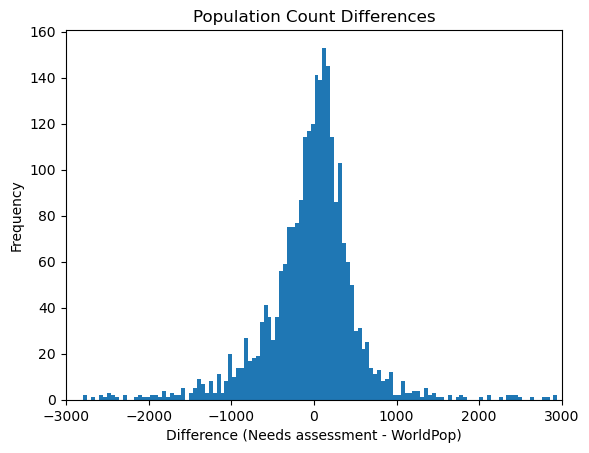

In [13]:
# Create histogram of difference
plt.hist(needs_assessment_worldpop["Difference"], bins=1000)
# Set x axis limits
plt.xlim(-3000, 3000)
# Set x and y axis labels
plt.xlabel("Difference (Needs assessment - WorldPop)")
plt.ylabel("Frequency")
# Set title
plt.title("Population Count Differences")
# Show plot
plt.show()

In [10]:
# Create boxplot of difference
#plt.boxplot(needs_assessment_worldpop["Difference"])
#plt.show()

In [12]:
# Export needs-assessment-worldpop gdf as geojson
#needs_assessment_worldpop.to_file(os.path.join(unsynced_path, "needs_assessment_worldpop_05_11.geojson"), driver="GeoJSON")

# Export needs-assessment-worldpop gdf as shapefile
#needs_assessment_worldpop.to_file(os.path.join(unsynced_path, "needs_assessment_worldpop_05_11.shp"), driver="ESRI Shapefile")